## Basic Steps

1. Run a baseline training script to build a speech commands model.
2. Add in your custom word to the training and test/validation sets.
   - Modify labels, shape of your output tensor in the model.
   - Make sure that feature extractor for the model aligns with the feature extractor 
     used in the arduino code.
3. Re-train model. => TF Model using floating-point numbers, that recognizes Google word and custom word.
4. Quantize the model and convert to TFlite. => keyword_model.tflite file
5. Convert tflite to .c file, using xxd => model_data.cc
6. Replace contents of existing micro_features_model.cpp with output of xxd.

All of the above steps are done in this notebook for the commands 'left', 'right'.

7. In micro_speech.ino, modify micro_op_resolver (around line 80) to add any necessary operations (DIFF_FROM_LECTURE)
8. In micro_features_model_settings.h, modify kSilenceIndex and kUnknownIndex, depending on 
where you have them in commands.  
  - Commands = ['left', 'right', '_silence', '_unknown'] => kSilenceIndex=2, kUnknownIndex=3
9. In micro_features_model_settings.cpp, modify kCategoryLabels to correspond to commands in this script.
10. In micro_features_micro_model_settings.h, set kFeatureSliceDurationMs, kFeatureSliceStrideMs to match what is passed to microfrontend as window_size, window_step, respectively.
11. Rebuild Arduino program, run it, recognize the two target words.
12. Experiment with model architecture, training parameters/methods, augmentation, more data-gathering, etc.

*Note*:  As of 5/3/21, this model uses 22% of flash and 49.5% of RAM, so there is substantial space to improve the model, but the latency is about 208ms, which is probably too slow.

In [72]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys

from tqdm.notebook import tqdm
# from tqdm import tqdm # replace with this if moving out of notebook

import os
import pathlib

from datetime import datetime as dt

from IPython import display

2.11.0


In [81]:
# Set seed for experiment reproducibility
seed = 215
tf.random.set_seed(seed)
np.random.seed(seed)

In [155]:
i16min = -2**15
i16max = 2**15-1
fsamp = 16000
wave_length_ms = 1000
wave_length_samps = int(wave_length_ms*fsamp/1000)
window_size_ms=60
window_step_ms=40
num_filters = 32
use_microfrontend = True
# dataset = 'mini-speech'
# dataset = 'full-speech-ds' # use the full speech commands as a pre-built TF dataset 
dataset = 'full-speech-files' # use the full speech commands stored as files 

silence_str = "_silence"  
unknown_str = "_unknown"
EPOCHS = 10

In [83]:
print(os.getenv("HOME"))

None


Apply the frontend to an example signal.

In [84]:
commands = ['apricot', 'marius'] 
if dataset == 'mini-speech':
  data_dir = pathlib.Path(os.path.join(os.getenv("HOME"), 'data/mini_speech_commands'))
  if not data_dir.exists():
    tf.keras.utils.get_file('mini_speech_commands.zip',
          origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
          extract=True, cache_dir='.', cache_subdir='data')
  # commands = np.array(tf.io.gfile.listdir(str(data_dir))) # if you want to use all the command words
  # commands = commands[commands != 'README.md']
elif dataset == 'full-speech-files':
  # data_dir = '/dfs/org/Holleman-Coursework/data/speech_dataset'
  data_dir = pathlib.Path(os.path.join(os.getcwd(), 'data'))

elif dataset == 'full-speech-ds':
    raise RuntimeError("full-speech-ds is not really supported yet")

In [85]:
data_dir

WindowsPath('C:/Users/ccm51/ECGR 4127/data')

In [86]:
label_list = commands.copy()
label_list.insert(0, silence_str)
label_list.insert(1, unknown_str)
print('label_list:', label_list)

label_list: ['_silence', '_unknown', 'apricot', 'marius']


In [87]:
!ls $data_dir/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [159]:
if dataset == 'mini-speech' or dataset == 'full-speech-files':
    filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav') 
    # with the next commented-out line, you can choose only files for words in label_list
    # filenames = tf.concat([tf.io.gfile.glob(str(data_dir) + '/' + cmd + '/*') for cmd in label_list], 0)
    filenames = tf.random.shuffle(filenames)
    num_samples = len(filenames)
    print('Number of total examples:', num_samples)
#     print('Number of examples per label:',
#           len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
    print('Example file tensor:', filenames[0])

Number of total examples: 60000
Example file tensor: tf.Tensor(b'C:\\Users\\ccm51\\ECGR 4127\\data\\_unknown\\_unknown_Sample3976_Noise0_Multiplier0.wav', shape=(), dtype=string)


In [89]:
filenames
# tf.strings.split(filenames[0], os.path.sep)[-2].numpy().decode('utf8')

<tf.Tensor: shape=(60000,), dtype=string, numpy=
array([b'C:\\Users\\ccm51\\ECGR 4127\\data\\marius\\marius_Sample1372_Noise3_Multiplier0.wav',
       b'C:\\Users\\ccm51\\ECGR 4127\\data\\_unknown\\_unknown_Pitch_Shift_0_1557.wav',
       b'C:\\Users\\ccm51\\ECGR 4127\\data\\apricot\\apricot_Sample755_Noise1_Multiplier0.wav',
       ...,
       b'C:\\Users\\ccm51\\ECGR 4127\\data\\_unknown\\_unknown_Sample3878_Noise3_Multiplier0.wav',
       b'C:\\Users\\ccm51\\ECGR 4127\\data\\_unknown\\_unknown_Sample1540_Noise3_Multiplier0.wav',
       b'C:\\Users\\ccm51\\ECGR 4127\\data\\_unknown\\_unknown_Sample3408_Noise0_Multiplier0.wav'],
      dtype=object)>

In [90]:
# Not really necessary, but just look at a few of the files to make sure that 
# they're the correct files, shuffled, etc.
for i in range(10):
    print(filenames[i].numpy().decode('utf8'))

C:\Users\ccm51\ECGR 4127\data\marius\marius_Sample1372_Noise3_Multiplier0.wav
C:\Users\ccm51\ECGR 4127\data\_unknown\_unknown_Pitch_Shift_0_1557.wav
C:\Users\ccm51\ECGR 4127\data\apricot\apricot_Sample755_Noise1_Multiplier0.wav
C:\Users\ccm51\ECGR 4127\data\_unknown\_unknown_Sample4377_Noise3_Multiplier0.wav
C:\Users\ccm51\ECGR 4127\data\_unknown\_unknown_Pitch_Shift_1_1468.wav
C:\Users\ccm51\ECGR 4127\data\_unknown\_unknown_Sample1712_Noise2_Multiplier0.wav
C:\Users\ccm51\ECGR 4127\data\_unknown\_unknown_Pitch_Shift_1_487.wav
C:\Users\ccm51\ECGR 4127\data\apricot\apricot_Sample281_Noise0_Multiplier0.wav
C:\Users\ccm51\ECGR 4127\data\apricot\apricot_Sample2849_Noise2_Multiplier0.wav
C:\Users\ccm51\ECGR 4127\data\apricot\apricot_Sample15_Noise1_Multiplier0.wav


In [160]:
# if dataset == 'mini-speech':
#   print('Using mini-speech')
num_train_files = int(0.6*num_samples) 
num_val_files = int(0.2*num_samples) 
num_test_files = num_samples - num_train_files - num_val_files
train_files = filenames[:num_train_files]
val_files = filenames[num_train_files: num_train_files + num_val_files]
test_files = filenames[-num_test_files:]
# elif dataset == 'full-speech-files':  
#   # the full speech-commands set lists which files are to be used
#   # as test and validation data; train with everything else
#   fname_val_files = os.path.join(data_dir, 'validation_list.txt')    
#   with open(fname_val_files) as fpi_val:
#     val_files = fpi_val.read().splitlines()
#   # validation_list.txt only lists partial paths
#   val_files = [os.path.join(data_dir, fn) for fn in val_files]
#   fname_test_files = os.path.join(data_dir, 'testing_list.txt')

#   with open(fname_test_files) as fpi_tst:
#     test_files = fpi_tst.read().splitlines()
#   # testing_list.txt only lists partial paths
#   test_files = [os.path.join(data_dir, fn).rstrip() for fn in test_files]    

#   # convert the TF tensor filenames into an array of strings so we can use basic python constructs
#   train_files = [f.decode('utf8') for f in filenames.numpy()]
#   # don't train with the _background_noise_ files; exclude when directory name starts with '_'
#   train_files = [f for f in train_files if f.split('/')[-2][0] != '_']
#   # validation and test files are listed explicitly in *_list.txt; train with everything else
#   train_files = list(set(train_files) - set(test_files) - set(val_files))
#   # now convert back into a TF tensor so we can use the tf.dataset pipeline
#   train_files = tf.constant(train_files)    
#   print("full-speech-files is in progress.  Good luck!")
# elif dataset == 'full-speech-ds':  
#     print("Using full-speech-ds. This is in progress.  Good luck!")
# else:
#   raise ValueError("dataset must be either full-speech-files, full-speech-ds or mini-speech")
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 36000
Validation set size 12000
Test set size 12000


In [92]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [93]:
# @tf.function
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  in_set = tf.reduce_any(parts[-2] == label_list)
  label = tf.cond(in_set, lambda: parts[-2], lambda: tf.constant(unknown_str))
  # print(f"parts[-2] = {parts[-2]}, in_set = {in_set}, label = {label}")
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return  label # parts[-2]

In [94]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [95]:
def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=num_filters,
                                    window_size=window_size_ms, window_step=window_step_ms)
  return spectrogram


Function to convert each waveform in a set into a spectrogram, then convert those
back into a dataset using `from_tensor_slices`.  (We should be able to use 
`wav_ds.map(get_spectrogram_and_label_id)`, but there is a problem with that process).
   

In [96]:
def create_silence_dataset(num_waves, samples_per_wave, rms_noise_range=[0.01,0.2], silent_label=silence_str):
    # create num_waves waveforms of white gaussian noise, with rms level drawn from rms_noise_range
    # to act as the "silence" dataset
    rng = np.random.default_rng()
    rms_noise_levels = rng.uniform(low=rms_noise_range[0], high=rms_noise_range[1], size=num_waves)
    rand_waves = np.zeros((num_waves, samples_per_wave), dtype=np.float32) # pre-allocate memory
    for i in range(num_waves):
        rand_waves[i,:] = rms_noise_levels[i]*rng.standard_normal(samples_per_wave)
    labels = [silent_label]*num_waves
    return tf.data.Dataset.from_tensor_slices((rand_waves, labels))  

In [97]:
def wavds2specds(waveform_ds, verbose=True):
  wav, label = next(waveform_ds.as_numpy_iterator())
  one_spec = get_spectrogram(wav)
  one_spec = tf.expand_dims(one_spec, axis=0)  # add a 'batch' dimension at the front
  one_spec = tf.expand_dims(one_spec, axis=-1) # add a singleton 'channel' dimension at the back    

  num_waves = 0 # count the waveforms so we can allocate the memory
  for wav, label in waveform_ds:
    num_waves += 1
    # print(num_waves)
  print(f"About to create spectrograms from {num_waves} waves")
  spec_shape = (num_waves,) + one_spec.shape[1:] 
  spec_grams = np.nan * np.zeros(spec_shape)  # allocate memory
  labels = np.nan * np.zeros(num_waves)
  idx = 0
  for wav, label in waveform_ds:    
    if verbose and idx % 250 == 0:
      print(f"\r {idx} wavs processed", end='')
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to 
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams[idx, ...] = spectrogram
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == np.array(label_list))    
    labels[idx] = new_label_id # for numeric labels
    # labels.append(new_label) # for string labels
    idx += 1
  labels = np.array(labels, dtype=int)
  output_ds = tf.data.Dataset.from_tensor_slices((spec_grams, labels))  
  return output_ds

# Edit

In [98]:
def wavds2specds(waveform_ds, verbose=True):
  wav, label = next(waveform_ds.as_numpy_iterator())
  one_spec = get_spectrogram(wav)
  one_spec = tf.expand_dims(one_spec, axis=0)  # add a 'batch' dimension at the front
  one_spec = tf.expand_dims(one_spec, axis=-1) # add a singleton 'channel' dimension at the back    

  num_waves = 0 # count the waveforms so we can allocate the memory
  for wav, label in waveform_ds:
    num_waves += 1
#     print(num_waves, label)
  print(f"About to create spectrograms from {num_waves} waves")
  spec_shape = (num_waves,) + one_spec.shape[1:] 
  spec_grams = np.nan * np.zeros(spec_shape)  # allocate memory
  labels = np.nan * np.zeros(num_waves)
  idx = 0
  for wav, label in waveform_ds:    
    if verbose and idx % 250 == 0:
      print(f"\r {idx} wavs processed", end='')
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to 
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams[idx, ...] = spectrogram
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == np.array(label_list))    
    labels[idx] = new_label_id # for numeric labels
    # labels.append(new_label) # for string labels
    idx += 1
  labels = np.array(labels, dtype=int)
  output_ds = tf.data.Dataset.from_tensor_slices((spec_grams, labels))  
  return output_ds

# Edit

In [99]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_train_files = len(train_files)
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
train_ds = wavds2specds(waveform_ds)

About to create spectrograms from 48000 waves
 47750 wavs processed

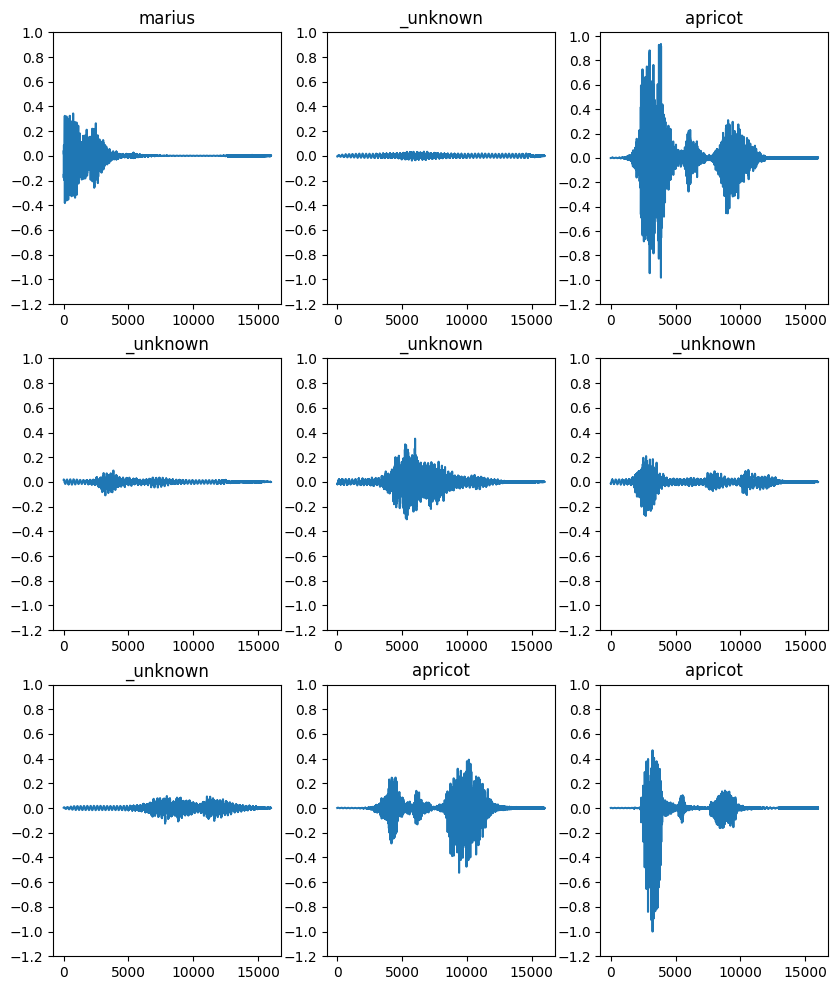

In [100]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [101]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: marius
Waveform shape: (16000,)
Spectrogram shape: (24, 32)
Audio playback


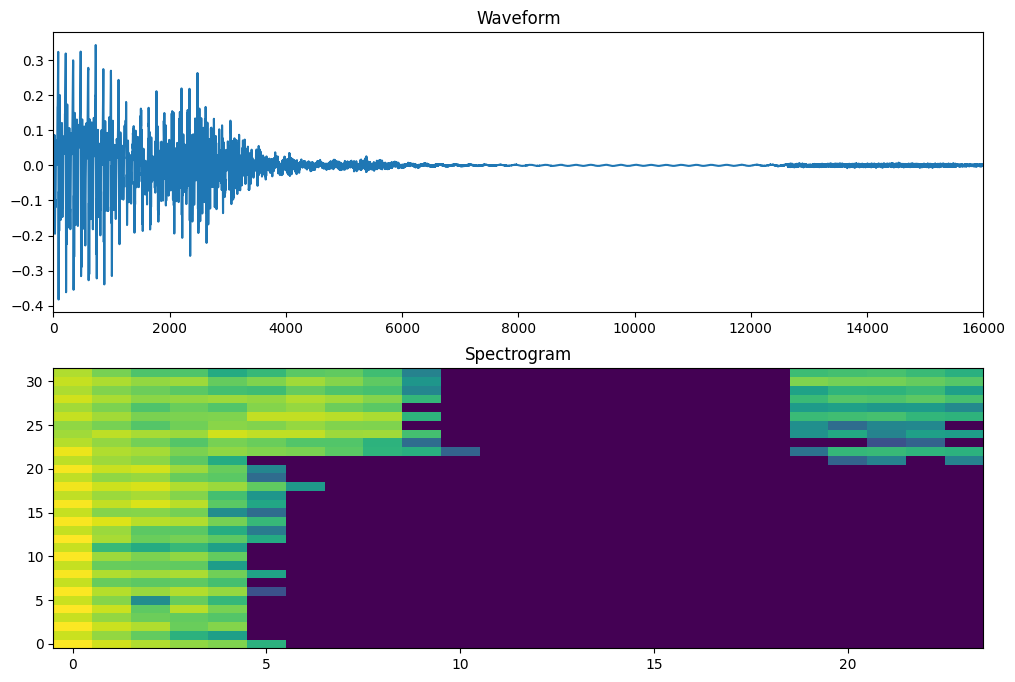

In [102]:
def plot_spectrogram(spectrogram, ax):
  # transpose so that the time is
  # represented in the x-axis (columns).
  freq_bins = spectrogram.shape[1]
  time_dur = spectrogram.shape[0]
  X = np.arange(time_dur)
  Y = range(freq_bins)
  ax.pcolormesh(X, Y, spectrogram.T)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [103]:
spectrogram.numpy().shape

(24, 32)

C:\Users\ccm51\AppData\Local\Temp\ipykernel_10432\1859809011.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.set_title(label_list[np.int(label_id)])


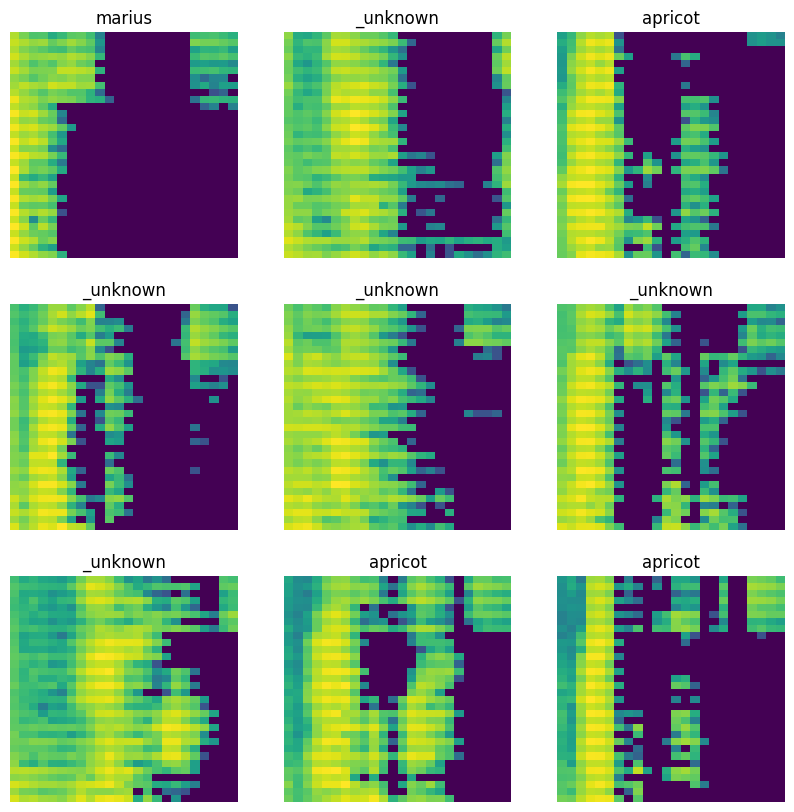

In [104]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(label_list[np.int(label_id)])
  ax.axis('off')

plt.show()

In [105]:
def copy_with_noise(ds_input, rms_level=0.25):
  rng = tf.random.Generator.from_seed(1234)
  wave_shape = tf.constant((wave_length_samps,))
  def add_noise(waveform, label):
    noise = rms_level*rng.normal(shape=wave_shape)
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)    
    noisy_wave = waveform + noise
    return noisy_wave, label

  return ds_input.map(add_noise)

In [106]:
# waveform_ds = augment_with_noise(waveform_ds)
count = 0
for w,l in waveform_ds:
  if w.shape != (16000,):
    print(f"element {count} has shape {w.shape}")
    break
  count += 1
print(count)

48000


In [107]:
def pad_16000(waveform, label):
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)        
    return waveform, label

In [108]:
def count_labels(dataset):
    counts = {}
    for _, lbl in dataset:
        if lbl.dtype == tf.string:
            label = lbl.numpy().decode('utf-8')
        else:
            label = lbl.numpy()
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    return counts

In [161]:
# Collect what we did to generate the training dataset into a 
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files, num_silent=None, noisy_reps_of_known=None):
  # if noisy_reps_of_known is not None, it should be a list of rms noise levels
  # For every target word in the data set, 1 copy will be created with each level 
  # of noise added to it.  So [0.1, 0.2] will add 2x noisy copies of the target words 
  if num_silent is None:
    num_silent = int(len(files))+1
  print(f"Processing {len(files)} files")
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label)
  if noisy_reps_of_known is not None:
    # create a few copies of only the target words to balance the distribution
    # create a tmp dataset with only the target words
    ds_only_cmds = waveform_ds.filter(lambda w,l: tf.reduce_any(l == commands))
    for noise_level in noisy_reps_of_known:
       waveform_ds = waveform_ds.concatenate(copy_with_noise(ds_only_cmds, rms_level=noise_level))
  if num_silent > 0:
    silent_wave_ds = create_silence_dataset(num_silent, wave_length_samps, 
                                            rms_noise_range=[0.01,0.2], 
                                            silent_label=silence_str)
    waveform_ds = waveform_ds.concatenate(silent_wave_ds)
  print(f"Added {num_silent} silent wavs and ?? noisy wavs")
  num_waves = 0
  output_ds = wavds2specds(waveform_ds)
  return output_ds

In [162]:
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")

We have 36000/12000/12000 training/validation/test files


In [163]:
# print(train_files[:20])
print(label_list)
train_files[:20]

tmp_ds = preprocess_dataset(train_files[:20])
print(count_labels(tmp_ds))

with tf.device('/CPU:0'): # needed on M1 mac
    tmp_ds = preprocess_dataset(train_files[:20], noisy_reps_of_known=[0.05,0.1])
    print(count_labels(tmp_ds))



['_silence', '_unknown', 'apricot', 'marius']
Processing 20 files
Added 21 silent wavs and ?? noisy wavs
About to create spectrograms from 41 waves
 0 wavs processed{1: 11, 2: 5, 3: 4, 0: 21}
Processing 20 files
Added 21 silent wavs and ?? noisy wavs
About to create spectrograms from 59 waves
 0 wavs processed{1: 11, 2: 15, 3: 12, 0: 21}


In [164]:
# train_ds is already done
with tf.device('/CPU:0'): # needed on M1 mac
    train_ds = preprocess_dataset(train_files, noisy_reps_of_known=[0.05,0.1,0.15,0.2,0.25])
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Processing 36000 files
Added 36001 silent wavs and ?? noisy wavs
About to create spectrograms from 162336 waves
 162250 wavs processedProcessing 12000 files
Added 12001 silent wavs and ?? noisy wavs
About to create spectrograms from 24001 waves
 24000 wavs processedProcessing 12000 files
Added 12001 silent wavs and ?? noisy wavs
About to create spectrograms from 24001 waves
 24000 wavs processed

In [165]:
print("training data set")
print(count_labels(train_ds))
print("val_ds data set")
print(count_labels(val_ds))
print("test_ds data set")
print(count_labels(test_ds))

training data set
{1: 17933, 2: 54462, 3: 53940, 0: 36001}
val_ds data set
{2: 2945, 3: 2970, 1: 6085, 0: 12001}
test_ds data set
{2: 2978, 1: 5982, 3: 3040, 0: 12001}


In [166]:
train_ds = train_ds.shuffle(int(len(train_files)*1.2))
val_ds = val_ds.shuffle(int(len(val_files)*1.2))
test_ds = test_ds.shuffle(int(len(test_files)*1.2))

In [167]:
batch_size = 256
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [168]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [169]:
for spectrogram, _ in train_ds.take(1):
  spec1 = spectrogram
# take(1) takes 1 *batch*, so we have to select the first 
# spectrogram from it, hence the [0]
print(f"Spectrogram shape {spec1[0].shape}")
print(f"ranges from {np.min(spec1)} to {np.max(spec1)}")   # min/max across the whole batch

Spectrogram shape (24, 32, 1)
ranges from 0.0 to 711.0


In [170]:
for spectrogram, _ in train_ds.take(1):
  # take(1) takes 1 *batch*, so we have to select the first 
  # spectrogram from it, hence the [0]
  input_shape = spectrogram[0].shape  
print('Input shape:', input_shape)
num_labels = len(label_list)


Input shape: (24, 32, 1)


In [171]:
model1 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.Conv2D(64, kernel_size=(1,1), activation="relu", padding='same'),    
    layers.BatchNormalization(), # optional, but may help convergence  
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),    
    layers.Conv2D(96, kernel_size=(1,1), strides=(4,4), activation="relu", padding='same'),      
    layers.MaxPooling2D(pool_size=(2, 2)), 
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(num_labels, activation='relu'),
], name="cnn_model_1")

model1.summary()

Model: "cnn_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d_11 (Depthw  (None, 24, 32, 1)        10        
 iseConv2D)                                                      
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 32, 64)        128       
                                                                 
 batch_normalization_18 (Bat  (None, 24, 32, 64)       256       
 chNormalization)                                                
                                                                 
 depthwise_conv2d_12 (Depthw  (None, 24, 32, 64)       640       
 iseConv2D)                                                      
                                                                 
 conv2d_19 (Conv2D)          (None, 6, 8, 96)          6240      
                                                       

In [172]:
model2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.Conv2D(32, kernel_size=(1,1), activation="relu", padding='same'),    
    layers.BatchNormalization(), # optional, but may help convergence  
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),    
    layers.Conv2D(64, kernel_size=(1,1), strides=(4,4), activation="relu", padding='same'),
    layers.BatchNormalization(), # optional, but may help convergence    
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),        
    layers.Conv2D(64, kernel_size=(1,1), activation="relu", padding='same'),        
    layers.BatchNormalization(), # optional, but may help convergence      
    layers.MaxPooling2D(pool_size=(4, 4)), 
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(num_labels, activation='relu'),
], name="cnn_model_2")

model2.summary()

Model: "cnn_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d_13 (Depthw  (None, 24, 32, 1)        10        
 iseConv2D)                                                      
                                                                 
 conv2d_20 (Conv2D)          (None, 24, 32, 32)        64        
                                                                 
 batch_normalization_20 (Bat  (None, 24, 32, 32)       128       
 chNormalization)                                                
                                                                 
 depthwise_conv2d_14 (Depthw  (None, 24, 32, 32)       320       
 iseConv2D)                                                      
                                                                 
 conv2d_21 (Conv2D)          (None, 6, 8, 64)          2112      
                                                       

In [173]:
model3 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(2, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="same"),
    layers.Conv2D(4, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="same"),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="same"),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_labels)
], name="cnn_model_3")

model3.summary()

Model: "cnn_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 24, 32, 2)         20        
                                                                 
 batch_normalization_24 (Bat  (None, 24, 32, 2)        8         
 chNormalization)                                                
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 16, 2)        0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 12, 16, 4)         76        
                                                                 
 batch_normalization_25 (Bat  (None, 12, 16, 4)        16        
 chNormalization)                                                
                                                       

In [174]:
model = model3

In [175]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [176]:
#  Google: feature extraction with Keras
# feature_model = tf.keras.model(input=model.input, output= model.layers[4].output)

In [177]:
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=int(2*EPOCHS)) 
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/20
635/635 [==============================] - 52s 80ms/step - loss: 0.7281 - accuracy: 0.6697 - val_loss: 4.6531 - val_accuracy: 0.4243
Epoch 2/20
635/635 [==============================] - 48s 76ms/step - loss: 0.4725 - accuracy: 0.8044 - val_loss: 2.0283 - val_accuracy: 0.4668
Epoch 3/20
635/635 [==============================] - 44s 69ms/step - loss: 0.3966 - accuracy: 0.8392 - val_loss: 3.6220 - val_accuracy: 0.4608
Epoch 4/20
635/635 [==============================] - 48s 75ms/step - loss: 0.3569 - accuracy: 0.8568 - val_loss: 2.4567 - val_accuracy: 0.4865
Epoch 5/20
635/635 [==============================] - 48s 76ms/step - loss: 0.3326 - accuracy: 0.8661 - val_loss: 1.8747 - val_accuracy: 0.4979
Epoch 6/20
635/635 [==============================] - 44s 69ms/step - loss: 0.3137 - accuracy: 0.8744 - val_loss: 1.7184 - val_accuracy: 0.5047
Epoch 7/20
635/635 [==============================] - 49s 78ms/step - loss: 0.2983 - accuracy: 0.8816 - val_loss: 1.2447 - val_accuracy:

In [178]:
date_str = dt.now().strftime("%d%b%Y_%H%M").lower()
model_file_name = f"project2_model_{date_str}.h5" 
print(f"Saving model to {model_file_name}")
model.save(model_file_name, overwrite=False)

Saving model to project2_model_08may2023_1053.h5


In [179]:
with open(model_file_name.split('.')[0] + '.txt', 'w') as fpo:
    fpo.write(f"i16min            = {i16min           }\n")
    fpo.write(f"i16max            = {i16max           }\n")
    fpo.write(f"fsamp             = {fsamp            }\n")
    fpo.write(f"wave_length_ms    = {wave_length_ms   }\n")
    fpo.write(f"wave_length_samps = {wave_length_samps}\n")
    fpo.write(f"window_size_ms    = {window_size_ms   }\n")
    fpo.write(f"window_step_ms    = {window_step_ms   }\n")
    fpo.write(f"num_filters       = {num_filters      }\n")
    fpo.write(f"use_microfrontend = {use_microfrontend}\n")
    fpo.write(f"label_list        = {label_list}\n")
    fpo.write(f"spectrogram_shape = {spectrogram.numpy().shape}\n")


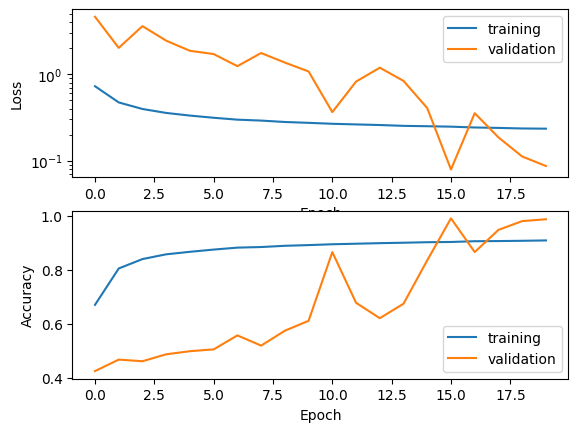

In [180]:
metrics = history.history
plt.subplot(2,1,1)
plt.semilogy(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(2,1,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [181]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [182]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

751/751 [==============================] - 3s 4ms/step
Test set accuracy: 99%


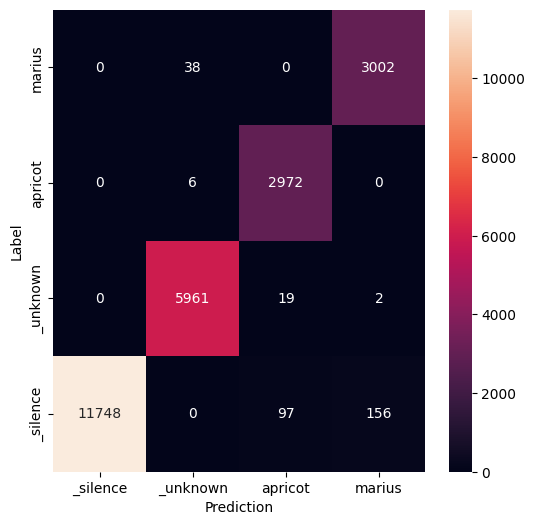

In [183]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

On training set:
5073/5073 [==============================] - 20s 4ms/step
Data set accuracy: 90%


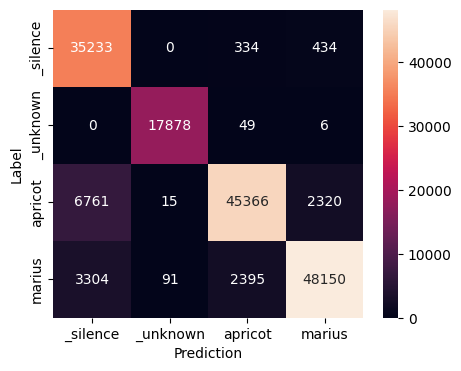

In [184]:
dset = train_ds.unbatch()
print("On training set:")

ds_audio = []
ds_labels = []

for audio, label in dset:
  ds_audio.append(audio.numpy())
  ds_labels.append(label.numpy())

ds_labels = np.array(ds_labels)
ds_audio = np.array(ds_audio)

model_out = model.predict(ds_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = ds_labels

ds_acc = sum(y_pred == y_true) / len(y_true)
print(f'Data set accuracy: {ds_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Processing 4 files
Added 1 silent wavs and ?? noisy wavs
About to create spectrograms from 5 waves
 0 wavs processed

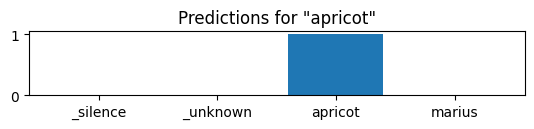

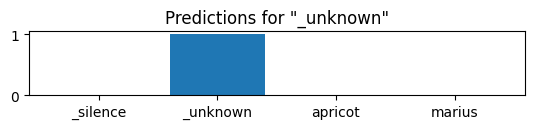

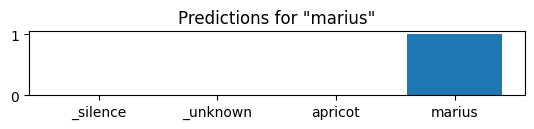

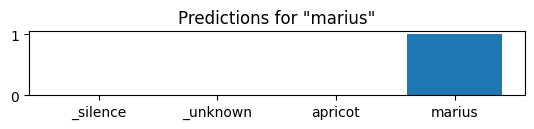

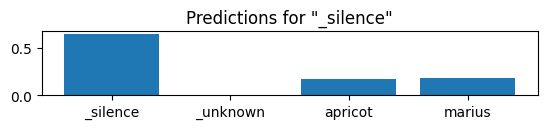

In [185]:
sample_files = [data_dir/'apricot/apricot_013428.wav', 
                data_dir/'_unknown/filler_203702.wav',  
                data_dir/'marius/marius_021450.wav',
                data_dir/'marius/marius_021514.wav']
fstr_list = [str(f) for f in sample_files]
sample_ds = preprocess_dataset(fstr_list, num_silent=1)
count = 1
for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.subplot(len(sample_files)+1, 1, count)
  plt.bar(label_list, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{label_list[label[0]]}"')
  plt.show()
  count += 1

In [186]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [187]:
history = model2.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS) 
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/10
635/635 [==============================] - 120s 187ms/step - loss: 0.6258 - accuracy: 0.7560 - val_loss: 0.5022 - val_accuracy: 0.7534
Epoch 2/10
635/635 [==============================] - 118s 186ms/step - loss: 0.3471 - accuracy: 0.8616 - val_loss: 3.4903 - val_accuracy: 0.4761
Epoch 3/10
635/635 [==============================] - 115s 181ms/step - loss: 0.2924 - accuracy: 0.8834 - val_loss: 2.9670 - val_accuracy: 0.4717
Epoch 4/10
635/635 [==============================] - 118s 187ms/step - loss: 0.2686 - accuracy: 0.8922 - val_loss: 0.2676 - val_accuracy: 0.8933
Epoch 5/10
635/635 [==============================] - 120s 189ms/step - loss: 0.2450 - accuracy: 0.9016 - val_loss: 0.0415 - val_accuracy: 0.9860
Epoch 6/10
635/635 [==============================] - 122s 193ms/step - loss: 0.2279 - accuracy: 0.9085 - val_loss: 0.6151 - val_accuracy: 0.7268
Epoch 7/10
635/635 [==============================] - 119s 188ms/step - loss: 0.2151 - accuracy: 0.9140 - val_loss: 11.6849 

In [188]:
date_str = dt.now().strftime("%d%b%Y_%H%M").lower()
model_file_name = f"project2_model_{date_str}.h5" 
print(f"Saving model to {model_file_name}")
model2.save(model_file_name, overwrite=False)

Saving model to project2_model_08may2023_1114.h5


In [189]:
with open(model_file_name.split('.')[0] + '.txt', 'w') as fpo:
    fpo.write(f"i16min            = {i16min           }\n")
    fpo.write(f"i16max            = {i16max           }\n")
    fpo.write(f"fsamp             = {fsamp            }\n")
    fpo.write(f"wave_length_ms    = {wave_length_ms   }\n")
    fpo.write(f"wave_length_samps = {wave_length_samps}\n")
    fpo.write(f"window_size_ms    = {window_size_ms   }\n")
    fpo.write(f"window_step_ms    = {window_step_ms   }\n")
    fpo.write(f"num_filters       = {num_filters      }\n")
    fpo.write(f"use_microfrontend = {use_microfrontend}\n")
    fpo.write(f"label_list        = {label_list}\n")
    fpo.write(f"spectrogram_shape = {spectrogram.numpy().shape}\n")


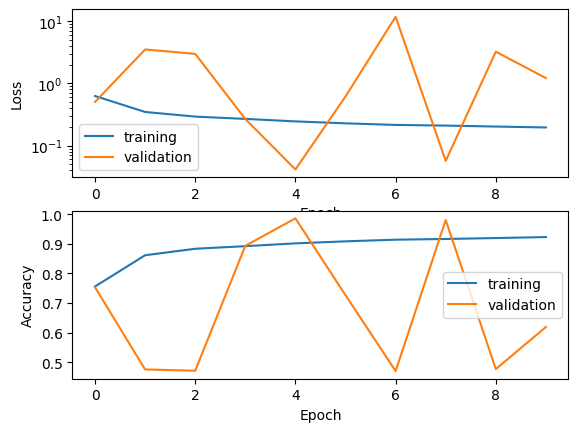

In [190]:
metrics = history.history
plt.subplot(2,1,1)
plt.semilogy(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(2,1,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [191]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [192]:
y_pred = np.argmax(model2.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

751/751 [==============================] - 10s 13ms/step
Test set accuracy: 62%


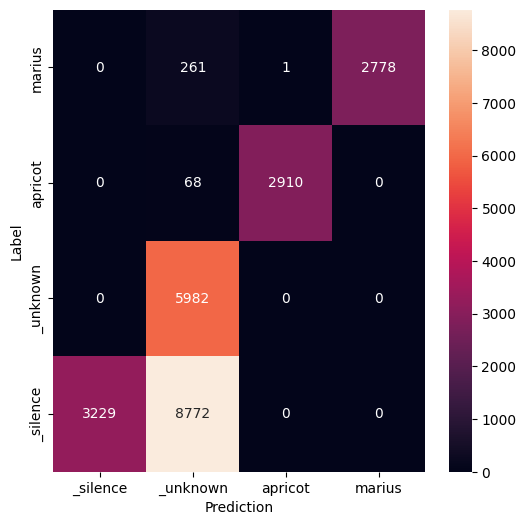

In [193]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

On training set:
5073/5073 [==============================] - 54s 11ms/step
Data set accuracy: 37%


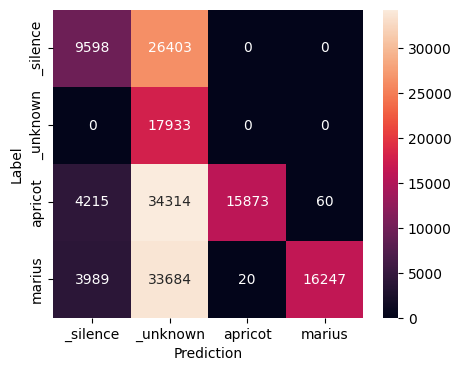

In [194]:
dset = train_ds.unbatch()
print("On training set:")

ds_audio = []
ds_labels = []

for audio, label in dset:
  ds_audio.append(audio.numpy())
  ds_labels.append(label.numpy())

ds_labels = np.array(ds_labels)
ds_audio = np.array(ds_audio)

model_out = model2.predict(ds_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = ds_labels

ds_acc = sum(y_pred == y_true) / len(y_true)
print(f'Data set accuracy: {ds_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Processing 4 files
Added 1 silent wavs and ?? noisy wavs
About to create spectrograms from 5 waves
 0 wavs processed

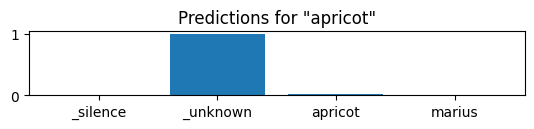

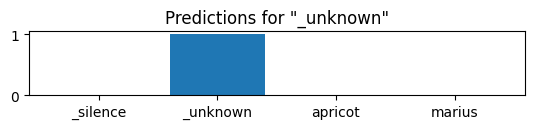

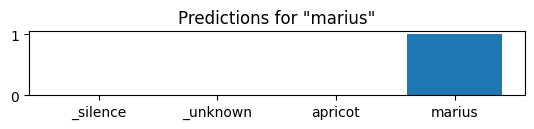

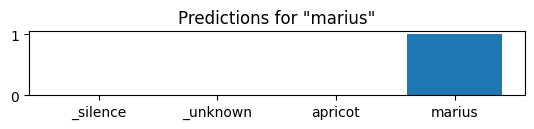

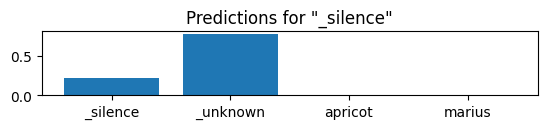

In [195]:
sample_files = [data_dir/'apricot/apricot_013428.wav', 
                data_dir/'_unknown/filler_203702.wav',  
                data_dir/'marius/marius_021450.wav',
                data_dir/'marius/marius_021514.wav']
fstr_list = [str(f) for f in sample_files]
sample_ds = preprocess_dataset(fstr_list, num_silent=1)
count = 1
for spectrogram, label in sample_ds.batch(1):
  prediction = model2(spectrogram)
  plt.subplot(len(sample_files)+1, 1, count)
  plt.bar(label_list, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{label_list[label[0]]}"')
  plt.show()
  count += 1

In [196]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [197]:
history = model1.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS) 
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/10
635/635 [==============================] - 180s 282ms/step - loss: 0.3641 - accuracy: 0.8579 - val_loss: 0.3374 - val_accuracy: 0.8895
Epoch 2/10
635/635 [==============================] - 180s 284ms/step - loss: 0.2769 - accuracy: 0.8933 - val_loss: 0.1397 - val_accuracy: 0.9588
Epoch 3/10
635/635 [==============================] - 183s 288ms/step - loss: 0.2426 - accuracy: 0.9063 - val_loss: 5.0652 - val_accuracy: 0.4547
Epoch 4/10
635/635 [==============================] - 178s 281ms/step - loss: 0.2249 - accuracy: 0.9128 - val_loss: 0.2127 - val_accuracy: 0.9498
Epoch 5/10
635/635 [==============================] - 184s 289ms/step - loss: 0.2103 - accuracy: 0.9181 - val_loss: 3.0135 - val_accuracy: 0.4805
Epoch 6/10
635/635 [==============================] - 181s 284ms/step - loss: 0.2030 - accuracy: 0.9207 - val_loss: 0.7335 - val_accuracy: 0.7013
Epoch 7/10
635/635 [==============================] - 182s 286ms/step - loss: 0.1920 - accuracy: 0.9248 - val_loss: 2.6640 -

In [198]:
date_str = dt.now().strftime("%d%b%Y_%H%M").lower()
model_file_name = f"project2_model_{date_str}.h5" 
print(f"Saving model to {model_file_name}")
model1.save(model_file_name, overwrite=False)

Saving model to project2_model_08may2023_1146.h5


In [199]:
with open(model_file_name.split('.')[0] + '.txt', 'w') as fpo:
    fpo.write(f"i16min            = {i16min           }\n")
    fpo.write(f"i16max            = {i16max           }\n")
    fpo.write(f"fsamp             = {fsamp            }\n")
    fpo.write(f"wave_length_ms    = {wave_length_ms   }\n")
    fpo.write(f"wave_length_samps = {wave_length_samps}\n")
    fpo.write(f"window_size_ms    = {window_size_ms   }\n")
    fpo.write(f"window_step_ms    = {window_step_ms   }\n")
    fpo.write(f"num_filters       = {num_filters      }\n")
    fpo.write(f"use_microfrontend = {use_microfrontend}\n")
    fpo.write(f"label_list        = {label_list}\n")
    fpo.write(f"spectrogram_shape = {spectrogram.numpy().shape}\n")


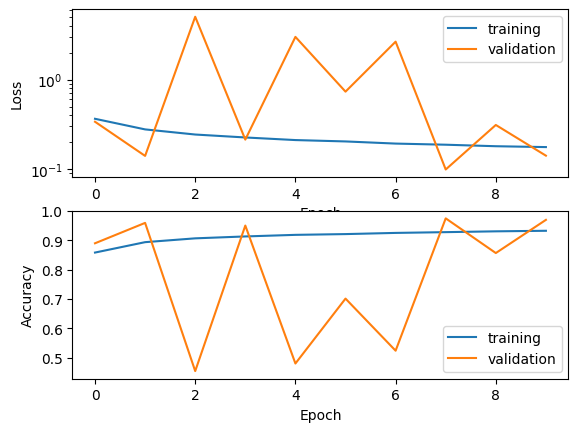

In [200]:
metrics = history.history
plt.subplot(2,1,1)
plt.semilogy(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(2,1,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [201]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [202]:
y_pred = np.argmax(model1.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

751/751 [==============================] - 12s 15ms/step
Test set accuracy: 97%


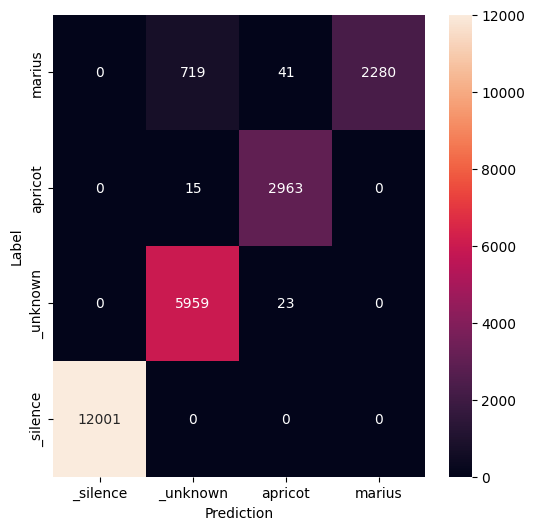

In [203]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

On training set:
5073/5073 [==============================] - 71s 14ms/step
Data set accuracy: 54%


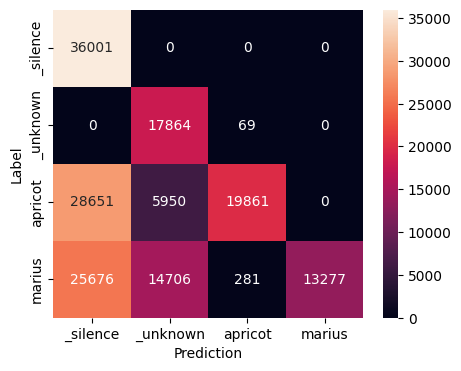

In [206]:
dset = train_ds.unbatch()
print("On training set:")

ds_audio = []
ds_labels = []

for audio, label in dset:
  ds_audio.append(audio.numpy())
  ds_labels.append(label.numpy())

ds_labels = np.array(ds_labels)
ds_audio = np.array(ds_audio)

model_out = model1.predict(ds_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = ds_labels

ds_acc = sum(y_pred == y_true) / len(y_true)
print(f'Data set accuracy: {ds_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Processing 4 files
Added 1 silent wavs and ?? noisy wavs
About to create spectrograms from 5 waves
 0 wavs processed

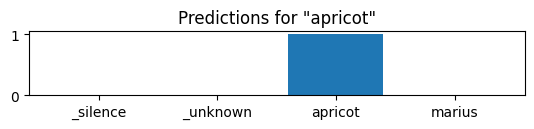

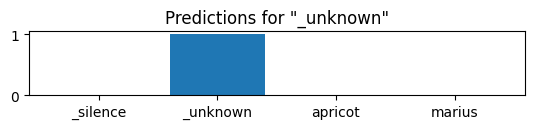

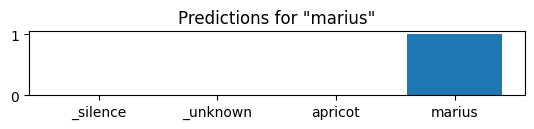

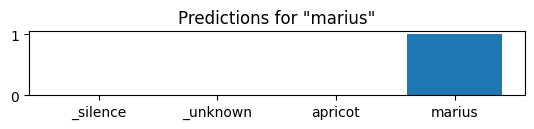

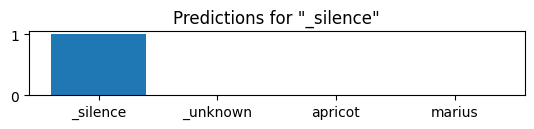

In [205]:
sample_files = [data_dir/'apricot/apricot_013428.wav', 
                data_dir/'_unknown/filler_203702.wav',  
                data_dir/'marius/marius_021450.wav',
                data_dir/'marius/marius_021514.wav']
fstr_list = [str(f) for f in sample_files]
sample_ds = preprocess_dataset(fstr_list, num_silent=1)
count = 1
for spectrogram, label in sample_ds.batch(1):
  prediction = model1(spectrogram)
  plt.subplot(len(sample_files)+1, 1, count)
  plt.bar(label_list, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{label_list[label[0]]}"')
  plt.show()
  count += 1

## Quantize and Convert to TFLite

In [212]:
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [213]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

In [214]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter.inference_output_type = tf.int8  # or tf.uint8

In [215]:
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ccm51\AppData\Local\Temp\tmpb4tw4a6z\assets


INFO:tensorflow:Assets written to: C:\Users\ccm51\AppData\Local\Temp\tmpb4tw4a6z\assets
C:\Users\ccm51\anaconda3\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [216]:
fname = 'model_1_final.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

Wrote 167600 / 167600 bytes to tflite file


In [150]:
!xxd -i kws_model.tflite >! model_3_final.cc

'xxd' is not recognized as an internal or external command,
operable program or batch file.
